In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#import all the required libs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb


from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers


In [4]:
file_path = '/content/drive/MyDrive/interview.data'
df_X = pd.read_csv(f'{file_path}/interview_X.csv')
df_Y = pd.read_csv(f'{file_path}/interview_y.csv')

# Visualize Data

In [ ]:
df_X.head()

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id
0,2021-07-21 19:25:47,00000000-0000-0001-6268-955448351062,0,7,6,530,iOS,iPhone XR,Mobile Phone,soaps.sheknows.com
1,2021-07-21 19:25:51,00000000-0000-0001-6268-955448381600,0,7,6,612,iOS,iPhone,Mobile Phone,www.forbes.com
2,2021-07-21 19:25:52,00000000-0000-0001-6268-955460621935,0,7,6,524,Android,SM-G998U,Mobile Phone,www.parents.com
3,2021-07-21 19:26:05,00000000-0000-0001-6268-955631601064,0,7,6,659,iOS,iPhone,Mobile Phone,livingforthesunshine.com
4,2021-07-21 19:26:05,00000000-0000-0001-6268-955659731502,0,7,6,505,iOS,iPhone,Mobile Phone,www.pro-football-reference.com


In [ ]:
df_X.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955239 entries, 0 to 955238
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reg_time     955239 non-null  object
 1   uid          955239 non-null  object
 2   fc_imp_chk   955239 non-null  int64 
 3   fc_time_chk  955239 non-null  int64 
 4   utmtr        955239 non-null  int64 
 5   mm_dma       955239 non-null  int64 
 6   osName       947347 non-null  object
 7   model        946844 non-null  object
 8   hardware     947054 non-null  object
 9   site_id      955239 non-null  object
dtypes: int64(4), object(6)
memory usage: 72.9+ MB


In [ ]:
#columns for which there are nan values

df_X.columns[df_X.isnull().any()]


Index(['osName', 'model', 'hardware'], dtype='object')

array([[<Axes: title={'center': 'fc_imp_chk'}>,
        <Axes: title={'center': 'fc_time_chk'}>],
       [<Axes: title={'center': 'utmtr'}>,
        <Axes: title={'center': 'mm_dma'}>]], dtype=object)

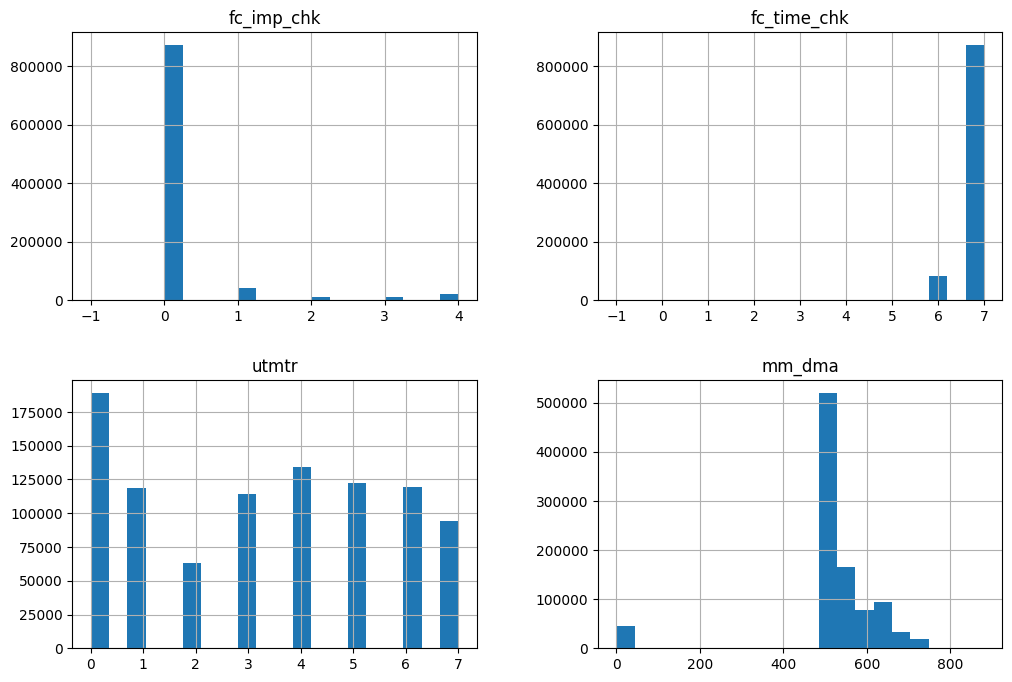

In [ ]:
df_X.hist(bins=20, figsize=(12, 8))

<ipython-input-4-221e0260f06a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df_X, palette='viridis', ax=axes[idx])
<ipython-input-4-221e0260f06a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df_X, palette='viridis', ax=axes[idx])
<ipython-input-4-221e0260f06a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=column, data=df_X, palette='viridis', ax=axes[idx])
<ipython-input-4-221e0260f06a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be remov

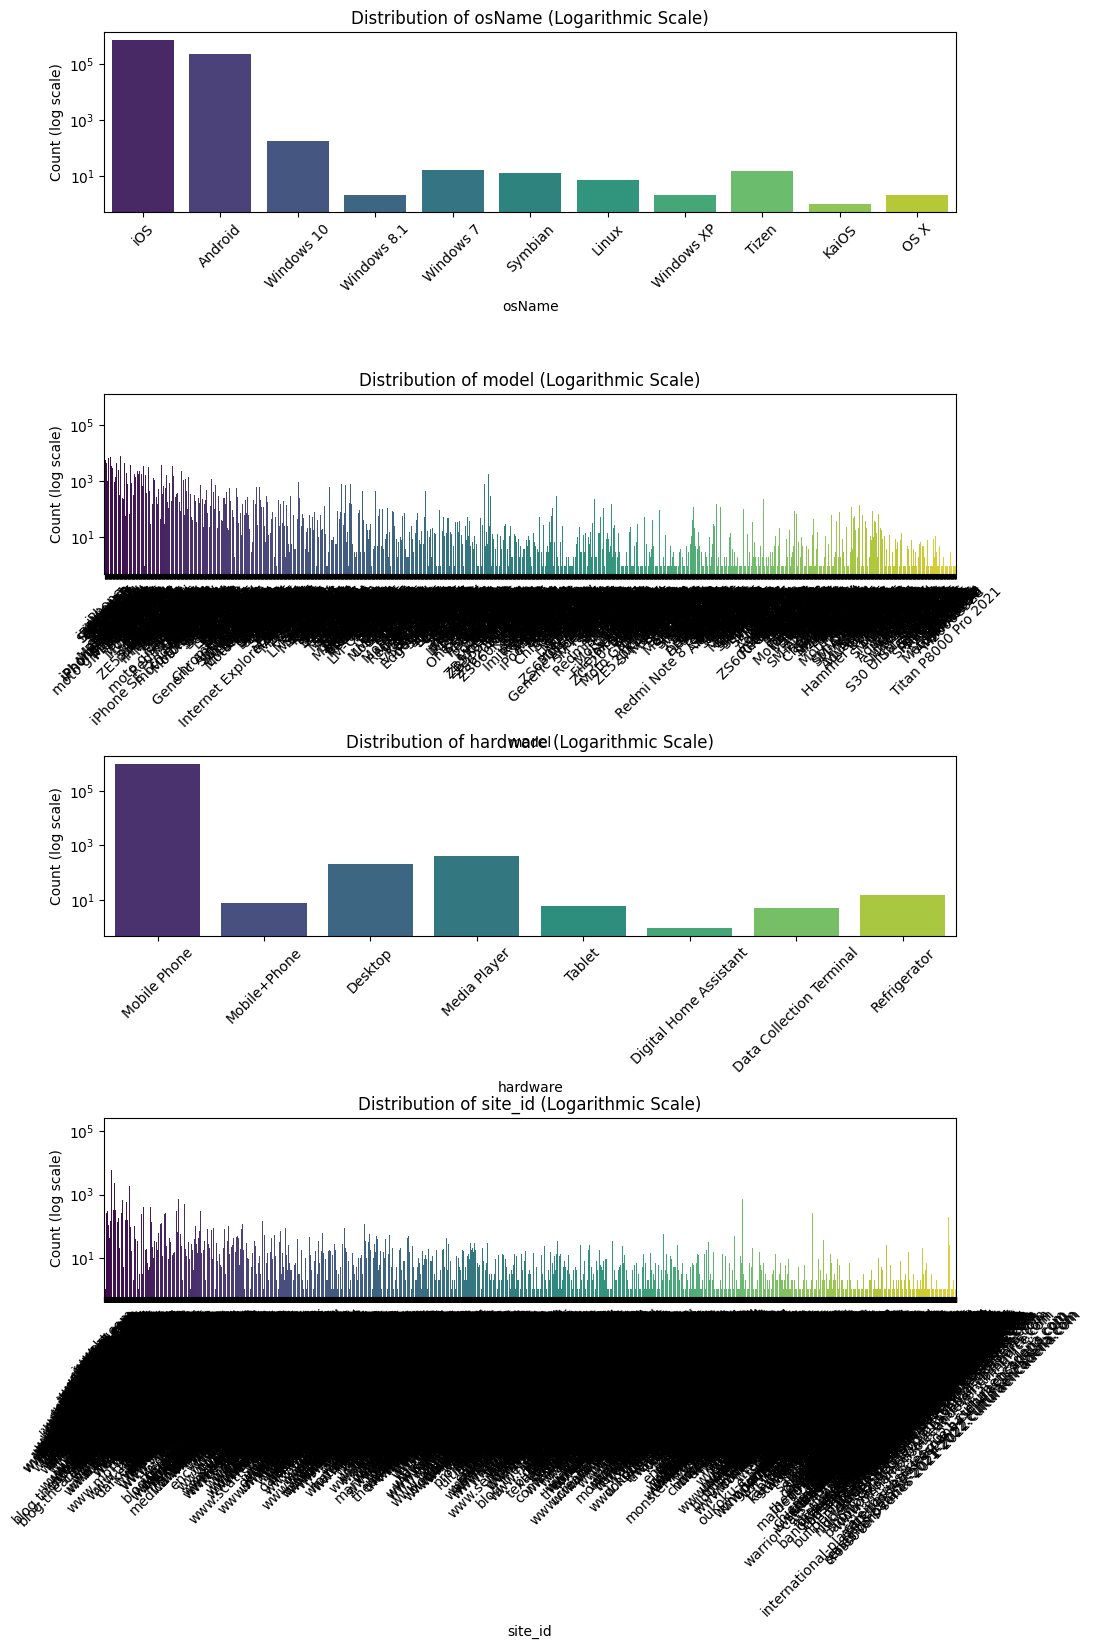

In [4]:
columns_to_plot = df_X.select_dtypes(include='object').columns.drop('uid').drop('reg_time')
# Set up subplots for the plots
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(12, 4 * len(columns_to_plot)))
fig.tight_layout(pad=15)

# Visualize the distribution pattern for each specified column on a logarithmic scale
for idx, column in enumerate(columns_to_plot):
    # Create subplot
    ax = sns.countplot(x=column, data=df_X, palette='viridis', ax=axes[idx])

    # Set y-axis to a logarithmic scale
    ax.set_yscale('log')

    # Set labels and title
    ax.set_xlabel(column)
    ax.set_ylabel('Count (log scale)')
    ax.set_title(f'Distribution of {column} (Logarithmic Scale)')

    # Rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=45)

plt.show()


In [ ]:
df_X['model'].value_counts()

iPhone               622333
iPhone 11             15933
iPhone XR             11520
iPhone 12 Pro Max      8405
SM-G973U               7833
                      ...  
G9                        1
TA-1052                   1
SM-A326BR/DS              1
5054N                     1
M20                       1
Name: model, Length: 1480, dtype: int64

In this example, I decide to exclude the '**model**' column from our dataset. The *model name* carries too much specificity. Instead, it is good practice to focus on the more general information provided by '**osname**' and '**hardware**'. This decision ensures that we retain the necessary information while embracing a more general and visually appealing approach.

In [ ]:
df_X['site_id'].value_counts()


www.dailymotion.com    150709
whatculture.com        102378
nypost.com              74063
www.digitalspy.com      28385
www.yahoo.com           19036
                        ...  
www.lefigaro.fr             1
rayanworld.com              1
www.routesnorth.com         1
mvlehti.net                 1
www.u-tv.ru                 1
Name: site_id, Length: 11290, dtype: int64

In [5]:
# Separate numerical and categorical variables
numerical_cols = df_X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_X.select_dtypes(include=['object']).columns.drop('reg_time').drop('uid').drop('model')


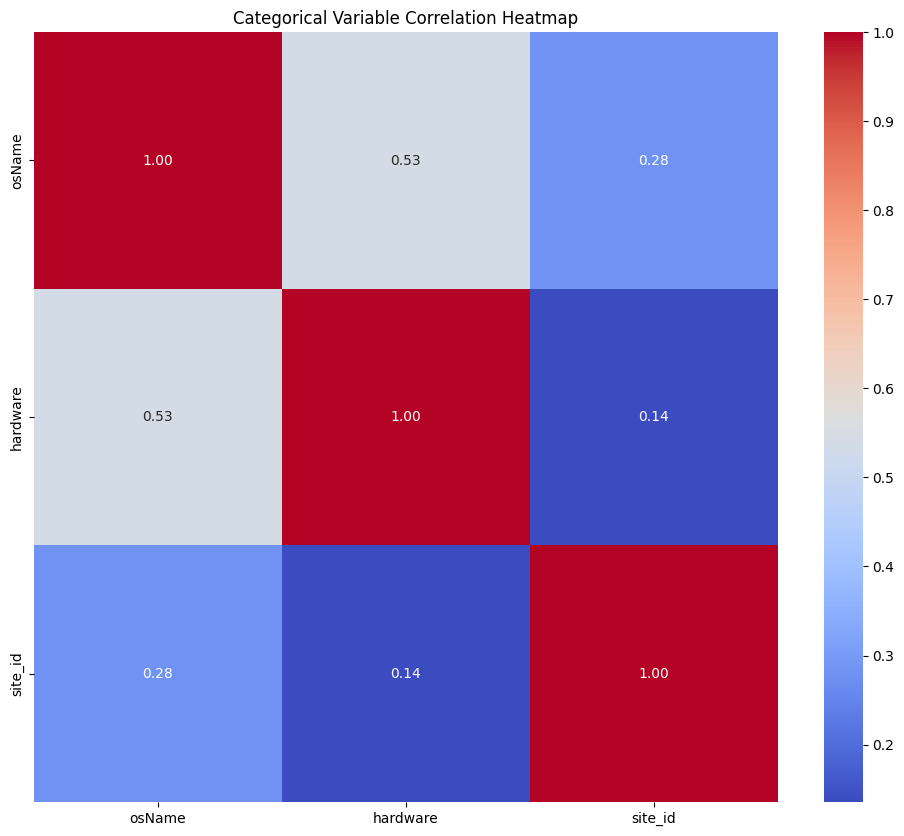

In [5]:
# Categorical Correlation Analysis
# Using Cramér's V for categorical variables

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_corr = pd.DataFrame(index=categorical_cols, columns=categorical_cols)
for i in range(len(categorical_cols) - 1):
    for j in range(i + 1, len(categorical_cols)):
        categorical_corr.at[categorical_cols[i], categorical_cols[j]] = cramers_v(df_X[categorical_cols[i]], df_X[categorical_cols[j]])


np.fill_diagonal(categorical_corr.values, 1.0)
categorical_corr = categorical_corr.combine_first(categorical_corr.transpose()).astype(float)

# Visualization of categorical correlation using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(categorical_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Categorical Variable Correlation Heatmap')
plt.show()

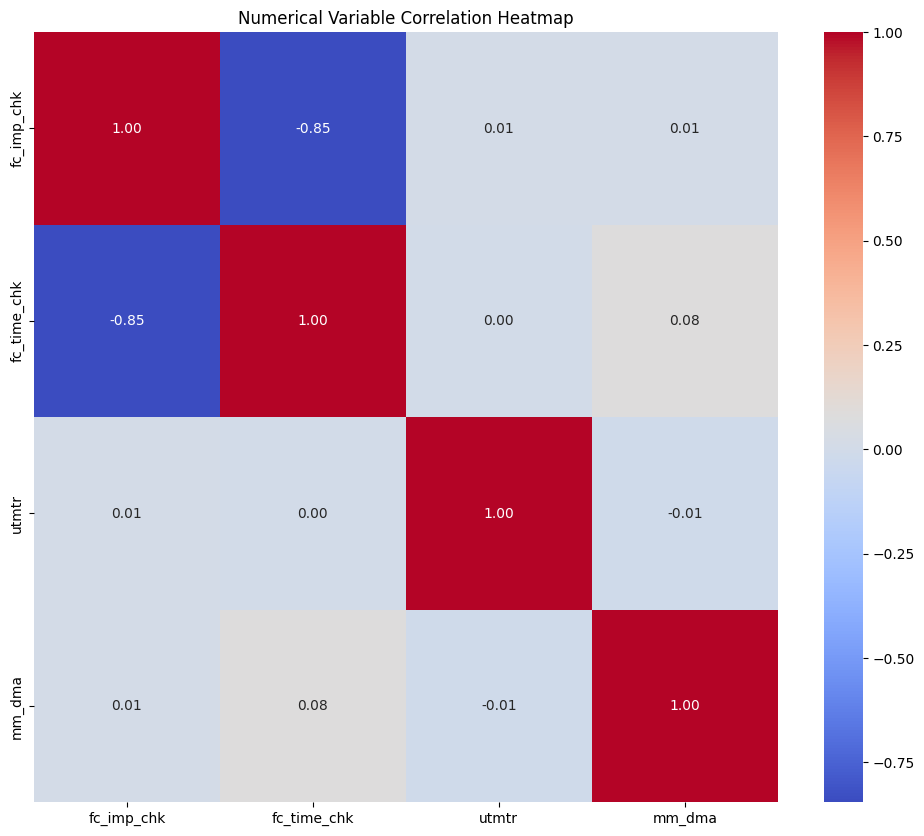

In [6]:
# Numerical Correlation Analysis
numerical_corr = df_X[numerical_cols].corr()

# Visualization of numerical correlation using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerical Variable Correlation Heatmap')
plt.show()

# Handling mistakes, duplicates, and incorrect information

At first, we can see that the **hardware** column contains entries such as *Mobile Phone* and *Mobile+Phone*, which logically should be grouped together for a more cohesive representation.

In [5]:
df_X['hardware'] = df_X['hardware'].replace({'Mobile+Phone': 'Mobile Phone'})

In the **osName** column, there exist distinct values like *Windows 10*, *Windows 8.1*, *Windows 7*, and *Windows XP*. Considering their similar data distribution and the general nature of the distinction between Windows versions, it would be beneficial to group them under a common category, say, *Windows*.

In [6]:
df_X['osName'] = df_X['osName'].replace({'Windows 10': 'Windows', 'Windows 8.1': 'Windows', 'Windows 7': 'Windows', 'Windows XP': 'Windows'})


In [7]:
df_X['hardware'].value_counts()

Mobile Phone                946423
Media Player                   396
Desktop                        208
Refrigerator                    15
Tablet                           6
Data Collection Terminal         5
Digital Home Assistant           1
Name: hardware, dtype: int64

In [8]:
df_X['osName'].value_counts()


iOS        712232
Android    234878
Windows       199
Tizen          15
Symbian        13
Linux           7
OS X            2
KaiOS           1
Name: osName, dtype: int64

In [9]:
df_X.drop_duplicates(inplace=True)

# Handling Missing Values

The columns with missing values are **osName**, **model**, and **hardware**. However, for our analysis, we will solely focus on **osName** and **hardware**, concentrating on handling NaN values in these specific columns.

1.  Considering the presence of the **model** column, we can effectively fill in the missing information in both **osName** and **hardware** with accurate details.

2.  **osName** inherently provides insights into the hardware, and vice versa. Therefore, leveraging the available information strategically allows us to address NaN values effectively in both columns.

Note: It is noteworthy that this approach is not accurate, especially because of the large number of potential values. By maintaining the ratio of these potential values, we can reasonably fill in the missing parts and increase the completeness of our dataset.

In [10]:
condition1 = ((df_X["osName"].isna()) | (df_X["hardware"].isna())) & (~df_X["model"].isna())
condition2 = (df_X["hardware"].isna()) & (~df_X["osName"].isna())
condition3 = (~df_X["hardware"].isna()) & (df_X["osName"].isna())

As we can se here there is no (Nan, model_name, Nan) row.

In [11]:
df_X[condition1]

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id


We can use the **osName** values to predict missing **hardware** values. For instance, if the **osName** is *'Android'*, it's likely that the corresponding hardware is a *'Mobile Phone'*. While it's also possible to be a *'Tablet'*, the abundance of data supporting *'Mobile Phone'* makes it the more probable label for prediction in this context.

In [12]:
#Fill the missing parts with hardware or osName value, but keeping the inital ratio of them.
def fill_na_based_on_ratios(row, key, existing_ratios, condition='condition2'):
  if condition == 'condition3':
    if pd.isnull(row['osName']) and row['hardware'] == key:
        return np.random.choice(existing_ratios.index, p=existing_ratios.values)
    else:
        return row['osName']
  else:
    if pd.isnull(row['hardware']) and row['osName'] == key:
        return np.random.choice(existing_ratios.index, p=existing_ratios.values)
    else:
        return row['hardware']

In [13]:
df_X[condition2]

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id
3048,2021-07-21 22:17:08,00000000-0000-0001-6269-058301371718,0,7,7,501,Android,NaN,NaN,abcnews.go.com
3277,2021-07-21 22:39:32,00000000-0000-0001-6269-071670571952,0,7,7,505,Android,NaN,NaN,boston.cbslocal.com
23197,2021-07-22 11:41:17,00000000-0000-0001-6269-540732851353,0,7,3,517,Android,NaN,NaN,www.live5news.com
45260,2021-07-22 16:35:59,00000000-0000-0001-6269-717589191559,0,7,5,505,Android,NaN,NaN,piunikaweb.com
47813,2021-07-22 17:07:34,00000000-0000-0001-6269-736514651484,0,7,5,563,Android,NaN,NaN,www.cnbc.com
...,...,...,...,...,...,...,...,...,...,...
905766,2021-08-06 01:12:51,00000000-0000-0001-6282-123676491910,2,6,0,501,Android,NaN,NaN,whatculture.com
905820,2021-08-06 01:13:27,00000000-0000-0001-6282-124017391087,2,6,0,501,Android,NaN,NaN,whatculture.com
905837,2021-08-06 01:13:37,00000000-0000-0001-6282-124179871225,2,6,0,501,Android,NaN,NaN,whatculture.com
905848,2021-08-06 01:13:52,00000000-0000-0001-6282-124274141823,2,6,0,501,Android,NaN,NaN,whatculture.com


In [14]:
# Get all the osName values
df_X[condition2]['osName'].value_counts()

Android    296
Name: osName, dtype: int64

In [15]:
for key in df_X[condition2]['osName'].value_counts().keys():

  # Getting the ratio of hardware values given the column osName
  existing_ratios = df_X[df_X['osName'] == key]['hardware'].value_counts(normalize=True)
  #Fill the missing parts with hardware or osName value based on condition, but keeping the inital ratio of them.
  df_X['hardware'] = df_X.apply(fill_na_based_on_ratios, axis=1, key=key, existing_ratios=existing_ratios, condition="condition2")

After filling in the missing values, we can check this using the same `condition2` parameter.


In [16]:
df_X[condition2]

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id
3048,2021-07-21 22:17:08,00000000-0000-0001-6269-058301371718,0,7,7,501,Android,NaN,Mobile Phone,abcnews.go.com
3277,2021-07-21 22:39:32,00000000-0000-0001-6269-071670571952,0,7,7,505,Android,NaN,Mobile Phone,boston.cbslocal.com
23197,2021-07-22 11:41:17,00000000-0000-0001-6269-540732851353,0,7,3,517,Android,NaN,Mobile Phone,www.live5news.com
45260,2021-07-22 16:35:59,00000000-0000-0001-6269-717589191559,0,7,5,505,Android,NaN,Mobile Phone,piunikaweb.com
47813,2021-07-22 17:07:34,00000000-0000-0001-6269-736514651484,0,7,5,563,Android,NaN,Mobile Phone,www.cnbc.com
...,...,...,...,...,...,...,...,...,...,...
905766,2021-08-06 01:12:51,00000000-0000-0001-6282-123676491910,2,6,0,501,Android,NaN,Mobile Phone,whatculture.com
905820,2021-08-06 01:13:27,00000000-0000-0001-6282-124017391087,2,6,0,501,Android,NaN,Mobile Phone,whatculture.com
905837,2021-08-06 01:13:37,00000000-0000-0001-6282-124179871225,2,6,0,501,Android,NaN,Mobile Phone,whatculture.com
905848,2021-08-06 01:13:52,00000000-0000-0001-6282-124274141823,2,6,0,501,Android,NaN,Mobile Phone,whatculture.com


We can use the **hardware** values to predict missing **osName** values. For example, if the **hardware** is *'Mobile Phone'*, it indicates that the **osName** is likely either *iOS* or *Android*. Although there is a possibility of it being *Symbian* or *KaiOS*, the abundance of data supporting *iOS* and *Android* makes them more probable labels. Therefore, the likely label for this scenario could be either *'iOS'* or *'Android'*.

In [17]:
df_X[condition3]

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id
102073,2021-07-23 16:47:09,00000000-0000-0001-6270-588308731759,0,7,5,659,NaN,NaN,Mobile Phone,www.hometalk.com
175088,2021-07-24 15:48:43,00000000-0000-0001-6271-417177151843,0,7,5,698,NaN,NaN,Mobile Phone,www.hometalk.com
443856,2021-07-29 10:43:48,00000000-0000-0001-6275-554282751807,0,7,3,501,NaN,NaN,Mobile Phone,pop.grid.id


In [18]:
# Get all the hardware values
df_X[condition3]['hardware'].value_counts()

Mobile Phone    3
Name: hardware, dtype: int64

In [19]:
for key in df_X[condition3]['hardware'].value_counts().keys():

  # Getting the ratio of osName values given the column hardware
  existing_ratios = df_X[df_X['hardware'] == key]['osName'].value_counts(normalize=True)

  #Fill the missing parts with hardware or osName value based on condition, but keeping the inital ratio of them.
  df_X['osName'] = df_X.apply(fill_na_based_on_ratios, axis=1, key=key, existing_ratios=existing_ratios, condition="condition3")

After filling the missed values, we can check it using the same *condition3* parameter.


In [20]:
df_X[condition3]

,reg_time,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,model,hardware,site_id
102073,2021-07-23 16:47:09,00000000-0000-0001-6270-588308731759,0,7,5,659,iOS,NaN,Mobile Phone,www.hometalk.com
175088,2021-07-24 15:48:43,00000000-0000-0001-6271-417177151843,0,7,5,698,iOS,NaN,Mobile Phone,www.hometalk.com
443856,2021-07-29 10:43:48,00000000-0000-0001-6275-554282751807,0,7,3,501,Android,NaN,Mobile Phone,pop.grid.id


# Handling the noisy distribution of **model** names (not required)


---




This part of the code shows some methods to solve this problem, if in some cases the model names are important to us and we need to combine similar phone models so as not to have such huge noisy data. So the goal here is to combine similar brands of the model name, which can somehow provide general information.

In [49]:
df_no_na = df_X.dropna()

In [50]:
df_no_na['model'].value_counts()

iPhone               622321
iPhone 11             15930
iPhone XR             11519
iPhone 12 Pro Max      8404
SM-G973U               7833
                      ...  
G9                        1
TA-1052                   1
SM-A326BR/DS              1
5054N                     1
M20                       1
Name: model, Length: 1480, dtype: int64

We can see here that there are various iPhone models separately, especially with variations and misspellings. So, we come up with the solution of a python function to aggregate all iPhone models into one count. It identifies iPhones by checking if the model name contains "iPhone" or closely matches it using fuzzy string matching. This approach ensures an accurate total count of iPhones, including those with varied or slightly misspelled names.

In [22]:
!pip install fuzzywuzzy
!python -m spacy download en_core_web_md

from fuzzywuzzy import fuzz

2024-01-22 19:05:59.366318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 19:05:59.366367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 19:05:59.367473: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 19:06:00.390286: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 22.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [51]:
# Take the first_name which is 'iPhone' in this case
first_name = df_no_na['model'].value_counts().keys()[0]


In [52]:
first_name

'iPhone'

In [53]:
# To demonstrate the logic
df_no_na_copy = df_no_na.copy()

In [54]:
def replace_with(value, replacement_word='iPhone', fuzzy_ratio_threshold=67):
    if replacement_word in value or fuzz.ratio(value, replacement_word) > fuzzy_ratio_threshold:
        return replacement_word
    else:
        return value

df_no_na['model'] = df_no_na['model'].apply(replace_with, replacement_word=first_name, fuzzy_ratio_threshold=67)

<ipython-input-54-a56c819ad783>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['model'] = df_no_na['model'].apply(replace_with, replacement_word=first_name, fuzzy_ratio_threshold=67)


In [28]:
print(f"Before\n\n {df_no_na_copy['model'].value_counts()}", f"\n\nAfter\n\n {df_no_na['model'].value_counts()}", sep='\n')

Before

 iPhone               622321
iPhone 11             15930
iPhone XR             11519
iPhone 12 Pro Max      8404
SM-G973U               7833
                      ...  
G9                        1
TA-1052                   1
SM-A326BR/DS              1
5054N                     1
M20                       1
Name: model, Length: 1480, dtype: int64


After

 iPhone      711842
SM-G973U      7833
SM-G991U      7691
SM-G960U      7094
SM-G975U      6745
             ...  
N5501L           1
SGH-T889         1
BKL-L04          1
N9136            1
M20              1
Name: model, Length: 1452, dtype: int64


In [60]:
# Doing the same logic for SM models
second_name = df_no_na['model'].value_counts().sort_values(ascending=False).keys()[1]

In [61]:
second_name

'SM-G973U'

In [62]:
df_no_na['model'] = df_no_na['model'].apply(replace_with, replacement_word='SM', fuzzy_ratio_threshold=67)

<ipython-input-62-8e4482f4cd8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['model'] = df_no_na['model'].apply(replace_with, replacement_word='SM', fuzzy_ratio_threshold=67)


In [64]:
df_no_na['model'] = df_no_na['model'].replace({'SM': 'Samsung'})
df_no_na['model'].value_counts()

<ipython-input-64-18976d2c2415>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_na['model'] = df_no_na['model'].replace({'SM': 'Samsung'})


iPhone              711842
Samsung             143469
Pixel 4a              3955
LM-Q730               3177
Pixel 3               2736
                     ...  
ZE520KL (Z017DC)         1
XT1635-02                1
SO-01J                   1
XT1064                   1
M20                      1
Name: model, Length: 1006, dtype: int64

The problem with this solution is that we have thousands of model names, it is inefficient to implement the same logic for each model name in such a scenario. So, we need a different approach.

The first thing that may come to mind is clustering, its implementation is shown below, first find the optimal number of clusters K, and then start clustering.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


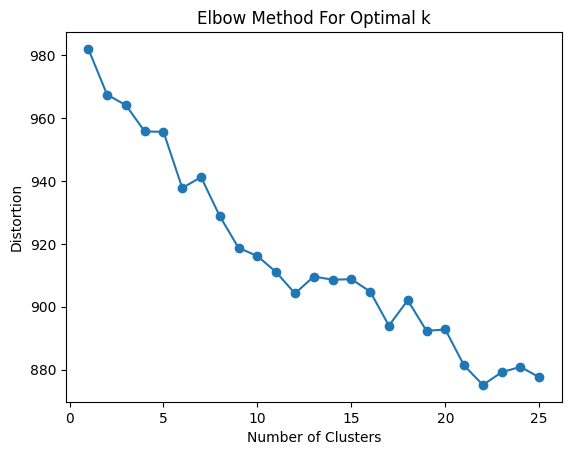

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# TF-IDF vectorization to convert model names into numerical features
vectorizer = TfidfVectorizer(analyzer='word', lowercase=True, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_no_na['model'].value_counts().keys())

distortions = []
max_clusters = 25
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(tfidf_matrix)
    distortions.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, max_clusters + 1), distortions, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.show()


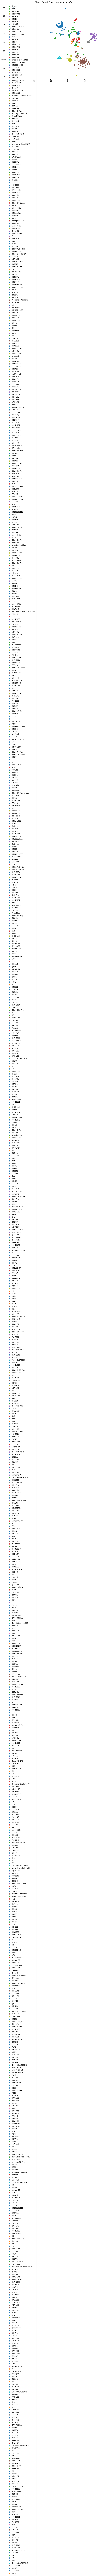

In [44]:
import spacy
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load spaCy's pre-trained word vectors
nlp = spacy.load("en_core_web_md")

phone_brands = df_no_na['model'].value_counts().keys()

# Vectorize phone brands using spaCy embeddings
brand_vectors = np.array([nlp(brand).vector for brand in phone_brands])

# Clustering
kmeans = KMeans(n_clusters=15, n_init=50)  # Adjust the number of clusters as needed
cluster_labels = kmeans.fit_predict(brand_vectors)

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(brand_vectors)

# Plot the clustered data
plt.figure(figsize=(10, 8))
for i in range(len(phone_brands)):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1], c=f'C{cluster_labels[i]}', label=phone_brands[i])

plt.title('Phone Brand Clustering using spaCy')
plt.legend()
plt.show()


However, here we also have a problem. Clustering based on string similarities in a dataset with noisy data can lead to inaccuracies. For instance, different Samsung models like "SM-G960U", "SM-G975U", and "M20" might be incorrectly grouped, as their names don't share obvious similarities, despite all being Samsung models.

The proposed approach combines text processing, fuzzy string matching, web scraping, and NLP to accurately categorize phone models into brands, especially in datasets where simple string comparison is insufficient due to noise and variation in model names.

The approach begins by querying Google for each phone model to find its brand. It then scrapes the search result page and processes the content through an NLP model to label words as organizations ('ORG'). These 'ORG' labels, presumed to be brand names, are collected. The most frequent words from this collection are then compared against a predefined list of known phone brands using fuzzy matching. The best-matched brand name from the list is selected to ensure consistency and avoid variations. If no match is found, the function labels the model as 'unknown'.

In [1]:
brand_list = [
    "Apple","Samsung","Huawei","Xiaomi","OnePlus","LG","Google","Sony","Motorola","Nokia","HTC","BlackBerry","Lenovo","OPPO","Vivo","Realme","ASUS","ZTE","Alcatel","TCL","Honor","Meizu","Infinix","Techno","Micromax","Lava","Panasonic","Sharp","LeEco","Essential","Fairphone","Poco","Redmi","Nubia","Razer","CAT","Kyocera","Palm","Vertu","Jolla","Wiko","YotaPhone","Zopo","Archos","Gigaset","HP","Microsoft","Dell","Acer","Blackview","Cubot","Doogee","Ulefone","Xolo","Yezz","ZUK",
]

In [66]:
import spacy
import requests
import re

from collections import Counter
from bs4 import BeautifulSoup


def find_most_frequent_word(strings, brand_list, fuzz_ratio_thresh=77, topK=5):
    # Combine all strings into a single text
    text = ' '.join(strings)

    # Extract words using regex
    words = re.findall(r'\b\w+\b', text.lower())

    # Count the occurrences of each word
    word_counts = Counter(words)

    # Find the most common words up to topK
    most_common_words = [word[0] for word in word_counts.most_common(topK)]

    # Find the word that is similar to the existing in the brand list
    for common_word in most_common_words:
      for brand_name in brand_list:
        if fuzz.partial_token_set_ratio(common_word, brand_name) > fuzz_ratio_thresh:
            return brand_name

    # If none, return 'unknown'
    return 'unknown'

# Load the spaCy English model with NER
nlp = spacy.load("en_core_web_sm")

#Iterating 25 times for demonstration the logic
i = 0
for model in df_no_na['model'].value_counts().keys():
    search_query = f"'{model}' name of brand"
    search_url = f"https://www.google.com/search?q={search_query}"

    response = requests.get(search_url)

    if response.status_code == 200:

        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract text from the webpage
        text = soup.get_text()

        # Process the text using spaCy
        doc = nlp(text)

        # Extract entities, assuming 'ORG' (organization) represents a brand
        phone_brands = [ent.text for ent in doc.ents if ent.label_ == 'ORG']

        # Find the most frequent brand name in the list or return 'unknown'
        most_frequent_brand = find_most_frequent_word(phone_brands, brand_list)
        print(f"{model} -> {most_frequent_brand}")
        i += 1

        if i == 25:
          break
    else:
      print(response.status_code, 'breaking ....')
      break

iPhone -> Apple
Samsung -> Samsung
Pixel 4a -> Google
LM-Q730 -> LG
Pixel 3 -> Google
LM-K500 -> LG
Pixel 5 -> Google
G013C -> Google
Moto G Stylus -> Motorola
Pixel 3a -> Google
MAR-LX1A -> Huawei
Moto G Power -> Motorola
G011C -> Google
Pixel 4 XL -> Google
LM-V600 -> LG
VOG-L29 -> Huawei
LM-Q720 -> LG
Pixel 4 -> Google
G011A -> Google
Pixel 3a XL -> Google
Moto Z4 -> Motorola
moto g play (2021) -> Motorola
Moto G7 Power -> Motorola
M2003J15SC -> Xiaomi
XT2075-1 -> Motorola


# Preprocessing Data

In [79]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 955215 entries, 0 to 955238
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   reg_time     955215 non-null  object
 1   uid          955215 non-null  object
 2   fc_imp_chk   955215 non-null  int64 
 3   fc_time_chk  955215 non-null  int64 
 4   utmtr        955215 non-null  int64 
 5   mm_dma       955215 non-null  int64 
 6   osName       947326 non-null  object
 7   model        946820 non-null  object
 8   hardware     947326 non-null  object
 9   site_id      955215 non-null  object
dtypes: int64(4), object(6)
memory usage: 80.2+ MB


In [21]:
df_X['weekDays'] = pd.to_datetime(df_X['reg_time']).dt.day_name()

In [22]:
df_X = df_X.drop(['reg_time', 'model'], axis=1)

In [23]:
df_X = df_X.dropna()

In [83]:
df_X['site_id'].str.startswith('www.').sum() > (~df_X['site_id'].str.startswith('www.')).sum()

True

In [24]:
def repl(value):
    value = value.strip()
    return 'www.' + value if not value.startswith('www.') else value

df_X['site_id'] = df_X['site_id'].apply(repl)

In [85]:
df_X['site_id'].value_counts()

www.dailymotion.com            150702
www.whatculture.com            102206
www.nypost.com                  73517
www.digitalspy.com              28377
www.yahoo.com                   19135
                                ...  
www.lolchess.gg                     1
www.diffuser.fm                     1
www.todayscreativeideas.com         1
www.dailybreeze.com                 1
www.u-tv.ru                         1
Name: site_id, Length: 11187, dtype: int64

In [25]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [26]:
cols_for_enc = df_X.select_dtypes(include=['object']).columns.drop('uid')
for col in cols_for_enc:
  col_enc = le.fit_transform(df_X[col])
  df_X[f'{col}_encoded'] = col_enc


In [88]:
df_X.corr()

<ipython-input-88-bacd8678a27a>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_X.corr()


,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName_encoded,hardware_encoded,site_id_encoded,weekDays_encoded
fc_imp_chk,1.000000,-0.848718,0.008553,0.004309,0.045282,0.002362,0.289900,0.076928
fc_time_chk,-0.848718,1.000000,0.003319,0.082642,-0.002643,-0.003142,-0.257236,-0.055066
utmtr,0.008553,0.003319,1.000000,-0.010768,-0.023419,-0.003078,0.037769,0.029622
mm_dma,0.004309,0.082642,-0.010768,1.000000,0.251638,0.042306,-0.007022,0.131853
osName_encoded,0.045282,-0.002643,-0.023419,0.251638,1.000000,-0.006526,-0.125788,0.150439
hardware_encoded,0.002362,-0.003142,-0.003078,0.042306,-0.006526,1.000000,-0.002840,-0.003120
site_id_encoded,0.289900,-0.257236,0.037769,-0.007022,-0.125788,-0.002840,1.000000,0.103811
weekDays_encoded,0.076928,-0.055066,0.029622,0.131853,0.150439,-0.003120,0.103811,1.000000


In [27]:
merged_df = pd.merge(df_X, df_Y, on='uid', how='left')

In [27]:
merged_df

,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,hardware,site_id,weekDays,osName_encoded,hardware_encoded,site_id_encoded,weekDays_encoded,tag
0,00000000-0000-0001-6268-955448351062,0,7,6,530,iOS,Mobile Phone,www.soaps.sheknows.com,Wednesday,7,4,8504,6,NaN
1,00000000-0000-0001-6268-955448381600,0,7,6,612,iOS,Mobile Phone,www.forbes.com,Wednesday,7,4,3347,6,NaN
2,00000000-0000-0001-6268-955460621935,0,7,6,524,Android,Mobile Phone,www.parents.com,Wednesday,0,4,7113,6,NaN
3,00000000-0000-0001-6268-955631601064,0,7,6,659,iOS,Mobile Phone,www.livingforthesunshine.com,Wednesday,7,4,5496,6,NaN
4,00000000-0000-0001-6268-955659731502,0,7,6,505,iOS,Mobile Phone,www.pro-football-reference.com,Wednesday,7,4,7499,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953021,00000000-0000-0001-6282-518776541959,1,6,4,524,iOS,Mobile Phone,www.forsythnews.com,Friday,7,4,3368,0,NaN
953022,00000000-0000-0001-6283-018960011814,0,7,0,524,Android,Mobile Phone,www.currently.att.yahoo.com,Saturday,0,4,2142,2,NaN
953023,00000000-0000-0001-6284-700631301210,0,7,0,0,Android,Mobile Phone,www.ladbible.com,Monday,0,4,5195,1,NaN
953024,00000000-0000-0001-6284-772865041722,0,7,0,0,iOS,Mobile Phone,www.ladbible.com,Monday,7,4,5195,1,NaN


In [28]:
train_data = merged_df[~merged_df['tag'].isnull()]

In [29]:
train_data

,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,hardware,site_id,weekDays,osName_encoded,hardware_encoded,site_id_encoded,weekDays_encoded,tag
71,00000000-0000-0001-6268-957597321099,0,7,6,517,Android,Mobile Phone,www.dotesports.com,Wednesday,0,4,2568,6,vcontent
79,00000000-0000-0001-6268-957946481763,0,7,6,505,Android,Mobile Phone,www.online.seterra.com,Wednesday,0,4,6928,6,vregistration
81,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,Mobile Phone,www.hiphopdx.com,Wednesday,7,4,4220,6,vregistration
82,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,Mobile Phone,www.hiphopdx.com,Wednesday,7,4,4220,6,vregistration
85,00000000-0000-0001-6268-958153731939,0,7,6,517,Android,Mobile Phone,www.vivaelbirdos.com,Wednesday,0,4,10521,6,vregistration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952568,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,Mobile Phone,www.digitalspy.com,Friday,7,4,2420,0,fclick
952569,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,Mobile Phone,www.digitalspy.com,Friday,7,4,2420,0,registration
952985,00000000-0000-0001-6282-636710091771,1,6,5,0,Android,Mobile Phone,www.digitalspy.com,Friday,0,4,2420,0,fclick
953009,00000000-0000-0001-6282-626705991151,3,6,5,567,iOS,Mobile Phone,www.whatculture.com,Friday,7,4,10722,0,vregistration


In [29]:
train_data['tag_encoded'] = train_data['tag'].apply(lambda x: 0 if x.startswith('v') else 1)

<ipython-input-29-f1eec33308b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tag_encoded'] = train_data['tag'].apply(lambda x: 0 if x.startswith('v') else 1)


In [31]:
train_data

,uid,fc_imp_chk,fc_time_chk,utmtr,mm_dma,osName,hardware,site_id,weekDays,osName_encoded,hardware_encoded,site_id_encoded,weekDays_encoded,tag,tag_encoded
71,00000000-0000-0001-6268-957597321099,0,7,6,517,Android,Mobile Phone,www.dotesports.com,Wednesday,0,4,2568,6,vcontent,0
79,00000000-0000-0001-6268-957946481763,0,7,6,505,Android,Mobile Phone,www.online.seterra.com,Wednesday,0,4,6928,6,vregistration,0
81,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,Mobile Phone,www.hiphopdx.com,Wednesday,7,4,4220,6,vregistration,0
82,00000000-0000-0001-6268-958052831367,0,7,6,501,iOS,Mobile Phone,www.hiphopdx.com,Wednesday,7,4,4220,6,vregistration,0
85,00000000-0000-0001-6268-958153731939,0,7,6,517,Android,Mobile Phone,www.vivaelbirdos.com,Wednesday,0,4,10521,6,vregistration,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952568,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,Mobile Phone,www.digitalspy.com,Friday,7,4,2420,0,fclick,1
952569,00000000-0000-0001-6282-630943861926,0,7,5,556,iOS,Mobile Phone,www.digitalspy.com,Friday,7,4,2420,0,registration,1
952985,00000000-0000-0001-6282-636710091771,1,6,5,0,Android,Mobile Phone,www.digitalspy.com,Friday,0,4,2420,0,fclick,1
953009,00000000-0000-0001-6282-626705991151,3,6,5,567,iOS,Mobile Phone,www.whatculture.com,Friday,7,4,10722,0,vregistration,0


In [95]:
train_data['tag'].value_counts()

vregistration    6242
registration     4174
fclick           3933
vcontent          497
vsignup           243
vlead              66
vmisc              46
signup             27
content            15
lead                6
misc                5
Name: tag, dtype: int64

In [96]:
train_data['tag_encoded'].value_counts()

1    8160
0    7094
Name: tag_encoded, dtype: int64

In [30]:
features = ['fc_imp_chk', 'fc_time_chk', 'utmtr', 'mm_dma', 'osName_encoded', 'hardware_encoded', 'site_id_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data['tag_encoded'], test_size=0.2, random_state=42)

#User Prompts


*   Identify Important Factors: Find out what factors are most likely to make someone click on online ads. Tell me which factors are the strongest predictors and rank them.

> *   Find the top factors that drive ad clicks
*   Rank features by their influence on ad clicks



*   Predict Click Probability: Can you create a model that tells us how likely it is for someone to click on an online ad? Use the data we have and provide an estimate of the probability.


> *   Build a model to predict ad click probabilities
*   Assess how well the click prediction model works
*   Improve the model's accuracy in predicting ad clicks



*   Assess the effectiveness of advertising on different devices based on clicks. Present the results in the form of an ordered list in descending order of performance along with the corresponding Click-Through Rates (CTR).


> *   Which types of devices get the most ad clicks, ranked from highest to lowest



*   Create targeting based on the top 10 DMAs (Designated Market Areas) by CTR.



> *   Identify the top 10 geographic areas where our ads perform best in terms of click rates


*   Propose targeting based on the top 5 best hours of the day by CTR. Present the results in the form of an ordered list in descending order of performance along with the corresponding CTR.


> *   What are the best times of day for ad clicks? List the top 5 hours by their click success rate




*   Which day of the week sees the highest click rates on our ads?
*   Discover patterns in user events like signups and registrations
*   Display the top 15 websites where our ads receive the most clicks









##  Identify Important Factors: Find out what factors are most likely to make someone click on online ads. Tell me which factors are the strongest predictors and rank them.

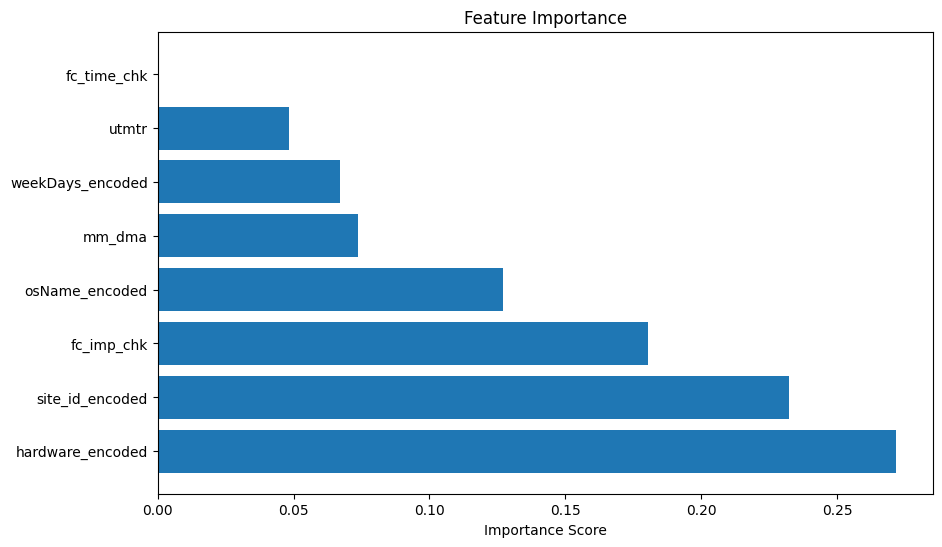

In [115]:
import xgboost as xgb

df = train_data.copy()

# Initialize the XGBoost classifier
model_XGBoost = xgb.XGBClassifier()

# Train the model
model_XGBoost.fit(X_train, y_train)

# Get feature importance scores
feature_importance = model_XGBoost.feature_importances_
feature_names = model_XGBoost.feature_names_in_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()


In [117]:
# Make predictions on the test set
y_pred = model_XGBoost.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model_XGBoost.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")
print("    \nConfusion Matrix:")
print(conf_matrix)

Accuracy:  0.8505
Precision: 0.8457
Recall:    0.8829
F1 Score:  0.8639
AUC-ROC:   0.9074
    
Confusion Matrix:
[[1148  264]
 [ 192 1447]]


## Predict Click Probability: Can you create a model that tells us how likely it is for someone to click on an online ad? Use the data we have and provide an estimate of the probability.

96/96 [==============================] - 0s 1ms/step
Accuracy:  0.7443
Precision: 0.7744
Recall:    0.7395
F1 Score:  0.7566
AUC-ROC:   0.8060
    
Confusion Matrix:
[[1059  353]
 [ 427 1212]]


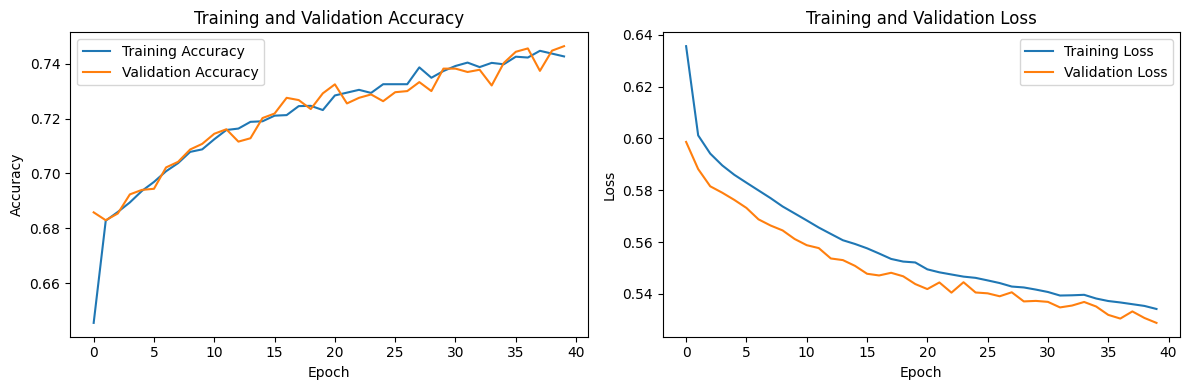

In [37]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Simple neural network
model_NN = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with monitoring of loss and accuracy on the validation set
history = model_NN.fit(X_train_scaled, y_train, epochs=40, batch_size=64, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_proba = model_NN.predict(X_test_scaled)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")
print("    \nConfusion Matrix:")
print(conf_matrix)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Improve the model's accuracy in predicting ad clicks

In [31]:
!pip install scikeras
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.6 MB/s eta 0:00:00


In [32]:
import optuna

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [41]:
# Using GridSearchCV


def create_model(neurons_layer1=16, neurons_layer2=16, optimizer='adam'):
    model = Sequential([
        Dense(neurons_layer1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(neurons_layer2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_NN = KerasClassifier(model=create_model, neurons_layer1=16, neurons_layer2=16, optimizer='Adam', epochs=10, batch_size=32, verbose=0)

# The hyperparameters to tune
param_grid = {
    'neurons_layer1': [16, 32, 64],
    'neurons_layer2': [8, 16, 32],
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

# Use GridSearchCV to find the best combination of hyperparameters
grid = GridSearchCV(estimator=model_NN, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: ", grid_result.best_score_)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters:  {'neurons_layer1': 16, 'neurons_layer2': 32, 'optimizer': 'sgd'}
Best Accuracy:  0.6259943351355778


In [35]:
# Using Bayesian Search


def create_model(trial):
    n_layers = trial.suggest_int('n_layers', 1, 3)

    model = Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
        model.add(Dense(num_hidden, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)
    model.fit(X_train_scaled, y_train, epochs=10, batch_size=batch_size, verbose=0)
    score = model.evaluate(X_test_scaled, y_test, verbose=0)
    return score[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

study.best_params


[I 2024-01-26 05:33:38,080] A new study created in memory with name: no-name-3fad7669-0764-4c3e-9c55-134e4c37540a
[I 2024-01-26 05:34:02,977] Trial 0 finished with value: 0.7089478969573975 and parameters: {'n_layers': 1, 'n_units_l0': 54, 'lr': 0.0012714503182020837, 'batch_size': 20}. Best is trial 0 with value: 0.7089478969573975.
[I 2024-01-26 05:34:07,251] Trial 1 finished with value: 0.6968207359313965 and parameters: {'n_layers': 2, 'n_units_l0': 13, 'n_units_l1': 39, 'lr': 0.0006288941060742033, 'batch_size': 114}. Best is trial 0 with value: 0.7089478969573975.
[I 2024-01-26 05:34:14,422] Trial 2 finished with value: 0.7318911552429199 and parameters: {'n_layers': 2, 'n_units_l0': 10, 'n_units_l1': 44, 'lr': 0.0198670181505231, 'batch_size': 65}. Best is trial 2 with value: 0.7318911552429199.
[I 2024-01-26 05:34:27,705] Trial 3 finished with value: 0.7282857894897461 and parameters: {'n_layers': 3, 'n_units_l0': 91, 'n_units_l1': 4, 'n_units_l2': 10, 'lr': 0.00826624157674666

{'n_layers': 3,
 'n_units_l0': 27,
 'n_units_l1': 127,
 'n_units_l2': 30,
 'lr': 0.0020895634410251626,
 'batch_size': 92}

As we have analysed and noticed above, the feature `'fc_time_chk'` is useless, so, let's remove it and update our *train/test* data. Although the feature 'site_id_encoded' may seem important for our output, it has too many specifics. Instead, we would use features describing websites that can provide general information, rather than the name of the website. We will imporve our feature set by adding `'weekDays_encoded'`. This feature offers additional insight into whether an ad is likely to be clicked, providing a different type of information compared to more specific features like `'reg_time'`.

In [44]:
features = ['fc_imp_chk', 'utmtr', 'mm_dma', 'osName_encoded', 'hardware_encoded', 'weekDays_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data['tag_encoded'], test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


By combining our observations, let's create the enhanced model.

In [41]:
n1 = study.best_params['n_units_l0']
n2 = study.best_params['n_units_l1']
n3 = study.best_params['n_units_l2']
lr = study.best_params['lr']
batch_size = study.best_params['batch_size']

96/96 [==============================] - 0s 2ms/step
Accuracy:  0.7103
Precision: 0.7428
Recall:    0.7047
F1 Score:  0.7232
AUC-ROC:   0.7819
    
Confusion Matrix:
[[1012  400]
 [ 484 1155]]


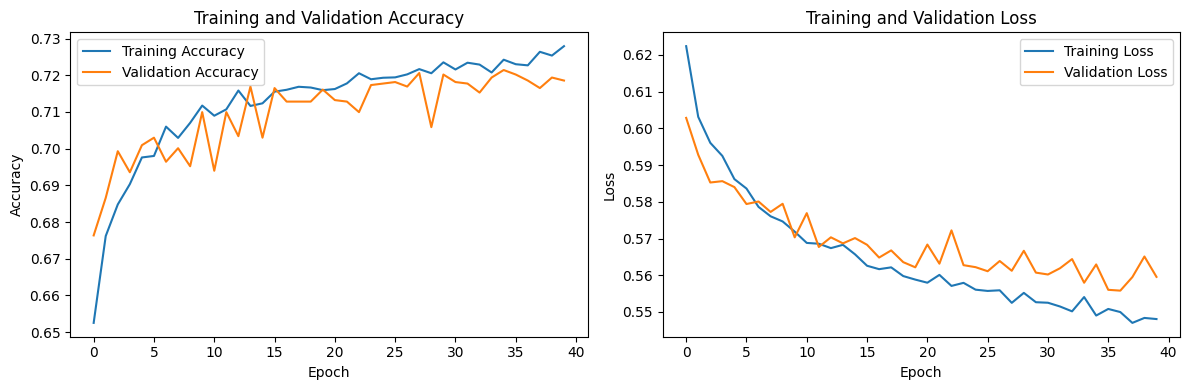

In [46]:
# Improved neural network
model_NN_imp = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


# Compile the model
model_NN_imp.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with monitoring of loss and accuracy on the validation set
history = model_NN_imp.fit(X_train_scaled, y_train, epochs=40, batch_size=batch_size, validation_split=0.2, verbose=0)

# Evaluate the model on the test set
y_pred_proba = model_NN_imp.predict(X_test_scaled)
y_pred = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}")
print("    \nConfusion Matrix:")
print(conf_matrix)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Assess the effectiveness of advertising on different devices based on clicks. Present the results in the form of an ordered list in descending order of performance along with the corresponding Click-Through Rates (CTR).

In [120]:
hardware_tag_counts = train_data.groupby('hardware')['tag'].value_counts().unstack().fillna(0)
impression_counts = train_data.groupby('hardware')['tag'].count()

CTR_hardware = (hardware_tag_counts['fclick'] / impression_counts) * 100

In [122]:
CTR_hardware.sort_values(ascending=False)

hardware
Desktop         35.600000
Media Player    33.333333
Tablet          28.571429
Mobile Phone    25.615369
dtype: float64

## Create targeting based on the top 10 DMAs (Designated Market Areas) by CTR.


In [123]:
mmdma_tag_counts = train_data.groupby('mm_dma')['tag'].value_counts().unstack().fillna(0)
mmdma_impression_counts = train_data.groupby('mm_dma')['tag'].count()

CTR_mmdma = (mmdma_tag_counts['fclick'] / mmdma_impression_counts) * 100

In [124]:
CTR_mmdma.sort_values(ascending=False).head(10)

mm_dma
531    100.000000
569     66.666667
547     42.857143
504     40.789474
519     39.759036
709     38.888889
746     38.461538
671     38.461538
686     38.461538
509     37.600000
dtype: float64

## Propose targeting based on the top 5 best hours of the day by CTR. Present the results in the form of an ordered list in descending order of performance along with the corresponding CTR.

In [142]:
utmtr_tag_counts = train_data.groupby('utmtr')['tag'].value_counts().unstack().fillna(0)
utmtr_impression_counts = train_data.groupby('utmtr')['tag'].count()

CTR_utmtr = (utmtr_tag_counts['fclick'] / utmtr_impression_counts) * 100

In [147]:
time_interval_mapping = {
    -1: 'N/A',
    0: '00:00 - 03:00',
    1: '03:00 - 06:00',
    2: '06:00 - 09:00',
    3: '09:00 - 12:00',
    4: '12:00 - 15:00',
    5: '15:00 - 18:00',
    6: '18:00 - 21:00',
    7: '21:00 - 00:00'
}
CTR_utmtr.rename(index=time_interval_mapping).sort_values(ascending=False).head(5)

utmtr
03:00 - 06:00    29.500948
21:00 - 00:00    28.696158
18:00 - 21:00    27.229602
06:00 - 09:00    26.184539
12:00 - 15:00    24.870017
dtype: float64

## Which day of the week sees the highest click rates on our ads?


In [149]:
weekDays_tag_counts = train_data.groupby('weekDays')['tag'].value_counts().unstack().fillna(0)
weekDays_impression_counts = train_data.groupby('weekDays')['tag'].count()

CTR_weekDays = (weekDays_tag_counts['fclick'] / weekDays_impression_counts) * 100

In [151]:
CTR_weekDays.sort_values(ascending=False).head(1)

weekDays
Friday    30.866246
dtype: float64

## Discover patterns in user events like signups and registrations


In [157]:
# Get all the user events
user_events = train_data[~train_data['tag'].str.startswith('v')]['tag'].value_counts().keys()

In [168]:
total_event_counts = train_data['tag'].value_counts()

# Initialize a DataFrame to store the ratios
df_event_ratios = pd.DataFrame(columns=['user_event', 'EvPM_score'])

# Calculate the ratio for each user event
for user_event in user_events:

    # Count occurrences of the user event (with and without 'v' prefix)
    user_event_counts = train_data[train_data['tag'].isin([user_event, 'v' + user_event])]['tag'].value_counts()

    # Calculate the ratio
    ratio = user_event_counts.sum() / total_event_counts.sum()

    # Append the result to the DataFrame
    df_event_ratios = pd.concat([df_event_ratios, pd.DataFrame({'user_event': [user_event], 'EvPM_score': [ratio]})], ignore_index=True)

In [169]:
df_event_ratios

,user_event,EvPM_score
0,registration,0.682837
1,fclick,0.257834
2,signup,0.017700
3,content,0.033565
4,lead,0.004720
5,misc,0.003343


## Display the top 15 websites where our ads receive the most clicks



In [152]:
website_tag_counts = train_data.groupby('site_id')['tag'].value_counts().unstack().fillna(0)
website_impression_counts = train_data.groupby('site_id')['tag'].count()

CTR_website = (website_tag_counts['fclick'] / website_impression_counts) * 100

In [153]:
CTR_website.sort_values(ascending=False).head(15)

site_id
www.whas11.com                 100.0
www.kolotv.com                 100.0
www.joaobidu.com.br            100.0
www.buzzaboutbees.net          100.0
www.nz.news.yahoo.com          100.0
www.twistedvoxel.com           100.0
www.vix.com                    100.0
www.k9ofmine.com               100.0
www.who13.com                  100.0
www.chef-in-training.com       100.0
www.cheeseheadtv.com           100.0
www.profesorjitaruionel.com    100.0
www.wtrf.com                   100.0
www.vindulge.com               100.0
www.media.11alive.com          100.0
dtype: float64